In [58]:
# importing the necessary python modules
# numpy and matplotlib are popular packages for scientific computing and plotting
import numpy as np
import matplotlib.pyplot as plt
import pygmsh

# interactive python (iPython) magic to instruct jupyter how to show the plots with respect to the code cells
%matplotlib inline

# various plotting parameters
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = 12

# scipy is an extension for numpy, used extensively in scientific computing
from scipy.sparse import linalg
from scipy.sparse import lil_matrix, csc_matrix
from scipy import stats

# here we import the functions translated from matlab
# to do so, we need to change the relative path
import sys
sys.path.append('../FEM')

from Mesher import Mesh
import Matrix
import PoroElasticProperties as prop

(4.999998, 5.000002)

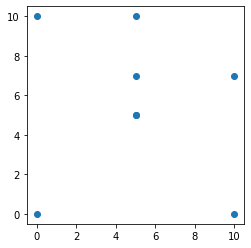

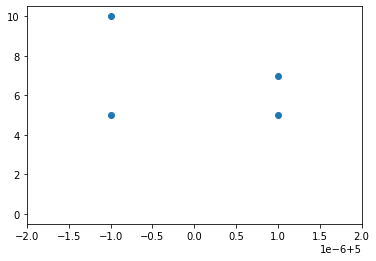

In [59]:
# we want to define the mesh's geometry
h1 = 10
h2 = 7
l1 = 5
l2 = 5
lwall = 1e-6
hwall = 5

vertices = np.array([[0, 0],
                     [0, h1],
                     [l1 - lwall, h1],
                     [l1 - lwall, h1 - hwall],
                     [l1 + lwall, h1 - hwall],
                     [l1 + lwall, h2],
                     [l1 + lwall + l2, h2],
                     [l1 + lwall + l2, 0]])

# we can take a look at what this looks like with matplotlib's scatter function
plt.figure()
plt.scatter(vertices[:, 0], vertices[:, 1])
plt.gca().set_aspect(1)

# we need to zoom in closer to see the wall's separation
plt.figure()
plt.scatter(vertices[:, 0], vertices[:, 1])
plt.xlim(l1 - 2*lwall, l1 + 2*lwall)


Text(0, 0.5, 'y (m)')

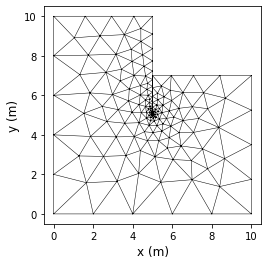

In [60]:
# we create a mesh with triangle finite elements with the pygmsh library.

# we can have a per point cell resolution, telling pygmsh where we want finer elements
# there are multiple ways to do this, but a simple one is to make a list as long as our points
resolutions = np.array([2, 2, 1, 0.05, 0.05, 1, 2, 2])

with pygmsh.geo.Geometry() as geom:
    # we initiate an empty line list
    lines = []

    # we instantiate points p1 and p2 and make sure to store the first one in p0
    p1 = p0 = geom.add_point(vertices[0], resolutions[0])

    # at every iteration, we make a line going from p1 to p2
    for i in range(len(vertices) - 1):
        p2 = geom.add_point(vertices[i + 1], resolutions[i + 1])
        line = geom.add_line(p1, p2)
        lines.append(line)
        p1 = p2  # we make sure that p1 becomes p2, the next point to be in lines

    # we add the last line, closing the loop with p2 to p0
    lines.append(geom.add_line(p2, p0))

    # curve loop is a collection of lines where every endpoints are connected
    loop = geom.add_curve_loop(lines)  

    # the plane surface is the area that is going to be partitionned in finite elements
    surf = geom.add_plane_surface(loop)

    # final command to do the computations
    out = geom.generate_mesh()

# we pass it to our wrapper object 'Mesh' with which we'll be interacting through our computations
mesh = Mesh(out)

# we can use the mesh.plot() function to easily show it

fig, ax = mesh.plot()
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

## Defining boundary conditions

To properly define the different boundary conditions of our problems, we need to have a map to the different nodes. In this problem, we will need to impose different boundary conditions at

- the impermeable sheet pile wall,
- the phreatic surface on the left side of the wall,
- the phreatic surface at the right side of the wall and
- the other boundaries (left, bottom and right edges).

We can access those nodes with `mesh.nodes`, of size `(number of nodes, 2)` and using conditional indexing. 


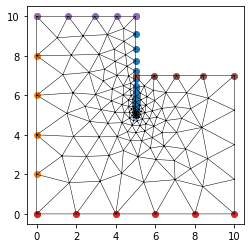

In [61]:
sheet_pile = np.argwhere((mesh.nodes[:, 0] == (l1 - lwall)) | (mesh.nodes[:, 0] == (l1 + lwall)) & (mesh.nodes[:, 1] >= hwall))[:, 0]

left = np.argwhere(mesh.nodes[:, 0] == 0)[:, 0]
right = np.argwhere(mesh.nodes[:, 0] == l1 + l2 + lwall)[:, 0]
bottom = np.argwhere(mesh.nodes[:, 1] == 0)[:, 0]

top_left = np.argwhere(mesh.nodes[:, 1] == h1)[:, 0]
top_right = np.argwhere((mesh.nodes[:, 1] == h2) & (l1 + lwall <= mesh.nodes[:, 0]))[:, 0]

mesh.plot()

for condition in (sheet_pile, left, right, bottom, top_left, top_right):
    plt.scatter(*mesh.nodes[condition].T)

(10,)
(159,)


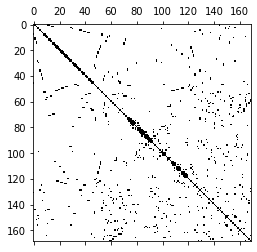

In [62]:
# we initiate a pressure vector for which we will solve with our system of equation
pressure = lil_matrix((mesh.nn, 1))
pressure[top_left] = h1
pressure[top_right] = h2

# we need to store our fixed nodes in a vector
fixed_nodes = np.hstack((top_left, top_right))
unknown_nodes = np.setdiff1d(np.arange(mesh.nn), fixed_nodes)
print(fixed_nodes.shape)
print(unknown_nodes.shape)

# we can build our conductivity matrix
permeability = 1
C = Matrix.assemble_conductivity_matrix(mesh, permeability)

plt.spy(C.toarray())

### Solving the system of equations

(see course notes)

In [63]:
# we can now compute the force vector
f = lil_matrix((mesh.nn, 1))

C_fixed = C[unknown_nodes][:, fixed_nodes]
C_unknown = C[unknown_nodes][:, unknown_nodes]

A = -C_fixed.dot(pressure[fixed_nodes])
pressure_unknown = linalg.spsolve(C_unknown, A)

pressure[unknown_nodes] = pressure_unknown

c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


### Plotting the results
We can look at the distribution of the pressure across our imaginary dam. We are also interested in the fluxes and it's magnitude. You can use the `project_flux` function programmed in the last lab.

Text(0.5, 1.0, 'h (m)')

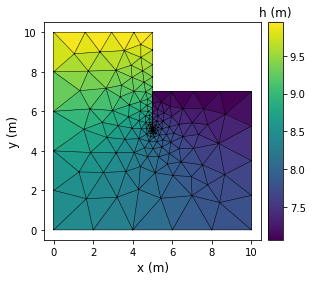

In [51]:
fig, ax, cb = mesh.plot(pressure.toarray()[:, 0], shading='flat')

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
cb.ax.set_title('h (m)')

c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
c:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


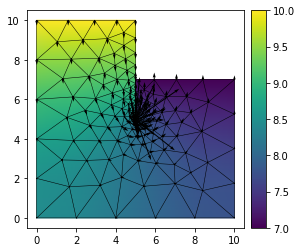

In [57]:
qx, qy = Matrix.project_flux(mesh, permeability, pressure)

fig, ax, cb = mesh.plot(pressure.toarray()[:, 0])
ax.quiver(mesh.nodes[:, 0], mesh.nodes[:, 1], qx, qy)
